# Benchmark Results Analysis

This notebook loads all JSON files under `bench/results` and summarizes the benchmark runs.


In [1]:
from __future__ import annotations

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results_dir = Path.cwd() / "results"
json_files = sorted(results_dir.glob("bench-runs-*.json"))
print(f"Found {len(json_files)} results files")

Found 12 results files


In [3]:
runs = []
rows = []

for path in json_files:
    payload = json.loads(path.read_text())
    file_id = path.stem
    for result in payload.get("results", []):
        runs.append({
            "file": file_id,
            "generatedAt": payload.get("generatedAt"),
            "run": result.get("run"),
            "success": result.get("success"),
            "exitCode": result.get("exitCode"),
            "durationMs": result.get("durationMs"),
            "status": result.get("status"),
        })
        for block in result.get("uiMetrics", []) or []:
            for row in block.get("rows", []) or []:
                trustworthiness = row.get("trustworthiness")
                quality_percent = trustworthiness * 100 if trustworthiness is not None else None
                wasm_features = row.get("wasmFeatures") or row.get("wasmMode", "")
                rows.append({
                    "file": file_id,
                    "scenario": row.get("scope", ""),
                    "Dataset": row.get("datasetName", ""),
                    "Run": row.get("runId"),
                    "Runtime (ms)": row.get("runtimeMs"),
                    "Memory (MB)": row.get("memoryDeltaMb"),
                    "Quality (%)": quality_percent,
                    "FPS": row.get("fpsAvg"),
                    "Latency (ms)": row.get("responsivenessMs"),
                    "WASM Features": wasm_features,
                    "datasetSize": row.get("datasetSize"),
                    "dimensions": row.get("dimensions"),
                })

runs_df = pd.DataFrame(runs)
rows_df = pd.DataFrame(rows)

print(f"Runs: {len(runs_df)}")
print(f"Rows: {len(rows_df)}")


Runs: 74
Rows: 108


In [ ]:
# Run-level overview
runs_df.groupby("success").size().rename("count")


: 

In [4]:
# Duration by file
runs_df.groupby("file")["durationMs"].agg(["count", "mean", "min", "max"]).sort_values("mean", ascending=False)


,count,mean,min,max
file,,,,
bench-runs-1769581231171,10,280047.100000,278326,281512
bench-runs-1769577567289,10,279824.000000,278965,281963
bench-runs-1769576313408,3,59406.666667,57189,63371
bench-runs-1769577028068,10,53854.800000,52546,57728
bench-runs-1769576149409,3,51906.333333,51295,53094
bench-runs-1769566314923,1,51834.000000,51834,51834
bench-runs-1769566570833,3,49924.000000,43239,58566
bench-runs-1769566422955,3,49073.000000,47005,50773
bench-runs-1769580748905,10,48160.700000,47602,48869


In [5]:
# Scenario-level summary
summary = (
    rows_df.groupby(["scenario", "WASM Features", "Dataset"], dropna=False)
    .agg(
        runs=("Run", "count"),
        runtime_ms_mean=("Runtime (ms)", "mean"),
        runtime_ms_p95=("Runtime (ms)", lambda s: s.quantile(0.95)),
        memory_mb_mean=("Memory (MB)", "mean"),
        quality_mean=("Quality (%)", "mean"),
        fps_mean=("FPS", "mean"),
        latency_ms_mean=("Latency (ms)", "mean"),
    )
    .reset_index()
    .sort_values("runtime_ms_mean", ascending=False)
)
summary.head(20)


,scenario,WASM Features,Dataset,runs,runtime_ms_mean,runtime_ms_p95,memory_mb_mean,quality_mean,fps_mean,latency_ms_mean
2,mid,none,Medium Clustered (1K points),10,5307.490000,6430.645,24.197082,94.447368,46.234131,41.146000
0,mid,"Dist,Tree,Matrix,NN,Opt",Medium Clustered (1K points),10,3685.380000,3811.285,20.664263,94.325017,33.636514,29.655333
3,mid,none,"Swiss Roll (1K points, 3D manifold)",10,3544.270000,3598.015,25.759776,99.663972,60.022560,0.000000
7,small,none,Small Random (100 points),17,3191.917647,3503.680,7.661960,87.190786,48.524638,21.095686
1,mid,"Dist,Tree,Matrix,NN,Opt","Swiss Roll (1K points, 3D manifold)",10,2416.730000,2462.445,22.715351,99.655435,48.658490,13.361250
6,small,none,"Iris Dataset (150 points, 4D)",17,2369.211765,2400.880,2.678417,98.765849,60.002282,0.000000
5,small,"Dist,Tree,Matrix,NN,Opt",Small Random (100 points),17,765.882353,946.500,-0.588871,84.992061,0.000000,19.069804
4,small,"Dist,Tree,Matrix,NN,Opt","Iris Dataset (150 points, 4D)",17,633.000000,733.900,6.617570,98.594473,0.000000,4.158088


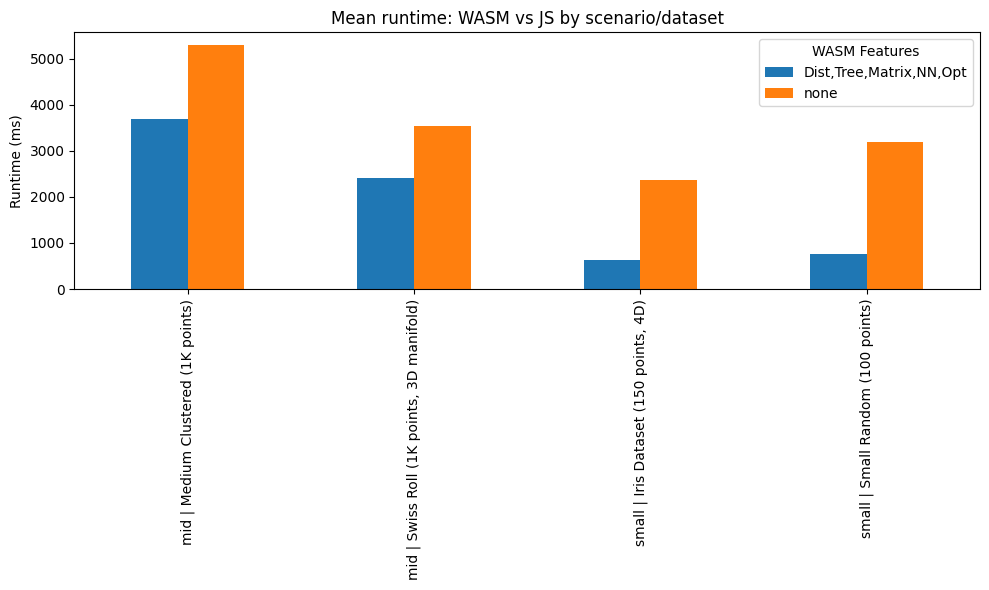

In [6]:
compare = (
    rows_df.groupby(["scenario", "Dataset", "WASM Features"], dropna=False)
    .agg(runtime_ms_mean=("Runtime (ms)", "mean"))
    .reset_index()
)

pivot = compare.pivot_table(
    index=["scenario", "Dataset"],
    columns="WASM Features",
    values="runtime_ms_mean",
)

plot_df = pivot.reset_index()
plot_df["label"] = plot_df["scenario"].astype(str) + " | " + plot_df["Dataset"].astype(str)
plot_df = plot_df.set_index("label").drop(columns=["scenario", "Dataset"])

ax = plot_df.plot(kind="bar", figsize=(10, 6))
ax.set_title("Mean runtime: WASM vs JS by scenario/dataset")
ax.set_ylabel("Runtime (ms)")
ax.set_xlabel("")
ax.legend(title="WASM Features")
plt.tight_layout()


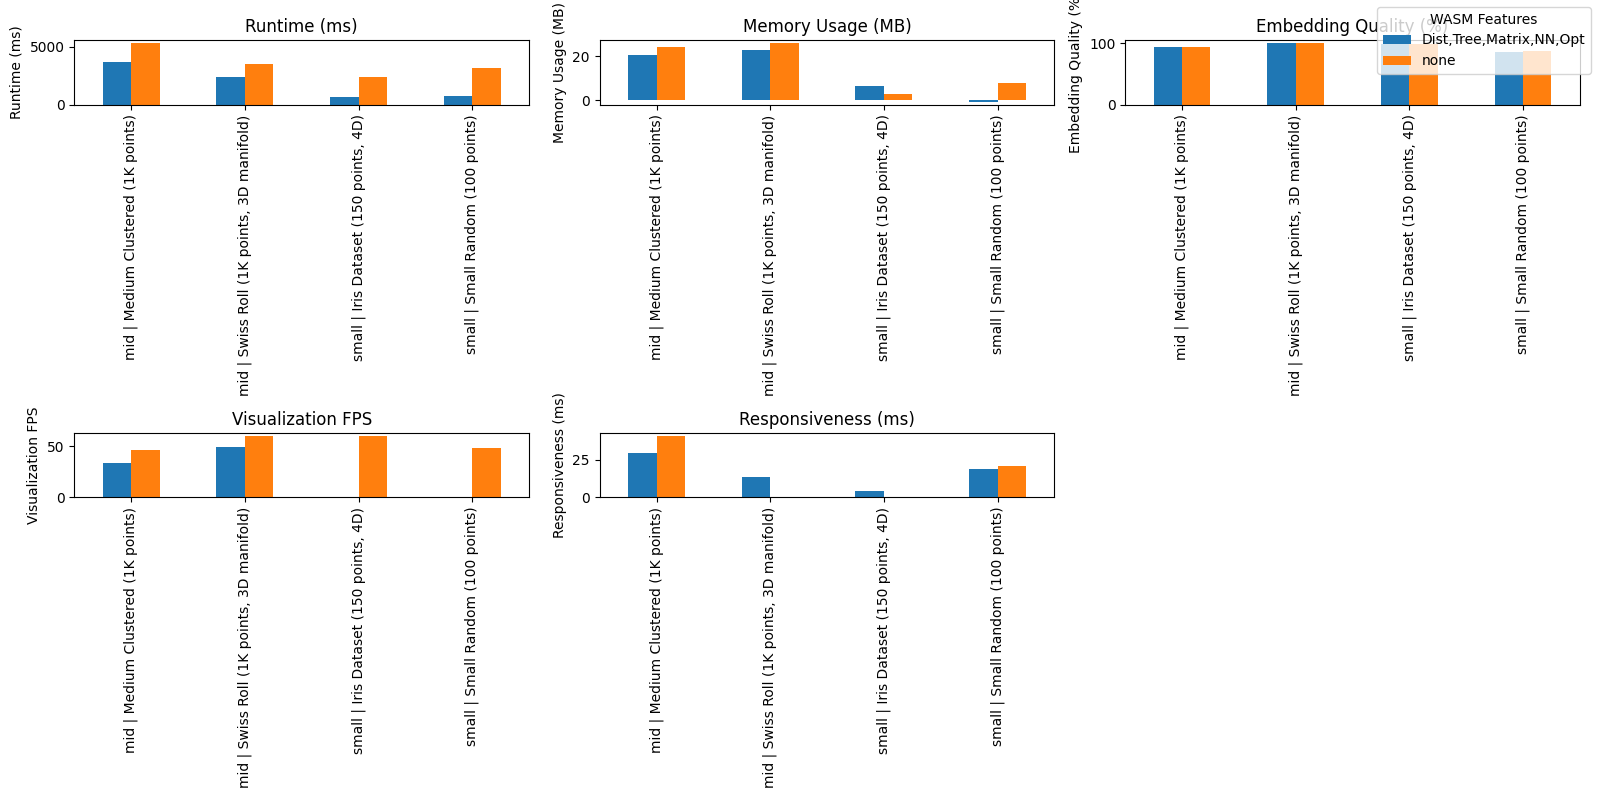

In [7]:
# Multi-metric comparison plots
if rows_df.empty:
    print("No UI metrics rows found.")
else:
    metrics = {
        "Runtime (ms)": "Runtime (ms)",
        "Memory Usage (MB)": "Memory (MB)",
        "Embedding Quality (%)": "Quality (%)",
        "Visualization FPS": "FPS",
        "Responsiveness (ms)": "Latency (ms)",
    }

    group_cols = ["scenario", "Dataset", "WASM Features"]
    mean_df = (
        rows_df.groupby(group_cols, dropna=False)
        .mean(numeric_only=True)
        .reset_index()
    )
    mean_df["label"] = mean_df["scenario"].astype(str) + " | " + mean_df["Dataset"].astype(str)

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.flatten()

    legend_handles = None
    legend_labels = None

    for i, (title, column) in enumerate(metrics.items()):
        pivot = mean_df.pivot_table(
            index="label",
            columns="WASM Features",
            values=column,
        ).sort_index()

        ax = axes[i]
        pivot.plot(kind="bar", ax=ax)
        ax.set_title(title)
        ax.set_ylabel(title)
        ax.set_xlabel("")

        if legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    for j in range(len(metrics), len(axes)):
        axes[j].set_visible(False)

    if legend_handles and legend_labels:
        fig.legend(legend_handles, legend_labels, title="WASM Features", loc="upper right")
    plt.tight_layout()
